In [1]:
# Assignment 7
# Analysis of accuracy decrease of tracking in conditions of biased state noise.
# Team 2:
#     Ekaterina Karmanova
#     Timur Chikichev
#     Iaroslav Okunevich
#     Nikita Mikhailovskiy
#
# Skoltech, 11.10.2019

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
#Constants
#Size of trajectory
c = 200
#Initial conditions
x1 = 5
v1 = 1
t = 1
#Variance of acceleration noise
sa = 0.2
s2a = sa**2
#Variance of measurements
sn = 20
s2n = sn**2

In [4]:
#Generating acceleration changes
a = np.random.normal(0,sa,c)
#Generating measurements
n = np.random.normal(0,sn,c)

In [5]:
#Presenting state equation
X1 = np.matrix((5,1))
F = np.matrix(((1,t),(0,1)))
G = np.matrix((t**2/2,t)).T
H = np.matrix((1,0))
#True trajectory
X = np.zeros([c,2])
X[0] = X1
for i in range (1,c):
    frst = np.matmul(F,np.asmatrix(X[i-1]).T)
    scnd = G.dot(a[i-1])
    X[i] = np.add(frst,scnd).T
#Measurements
Z = np.zeros(c)
for i in range (c):
    Z[i] = H.dot(X[i])+n[i]

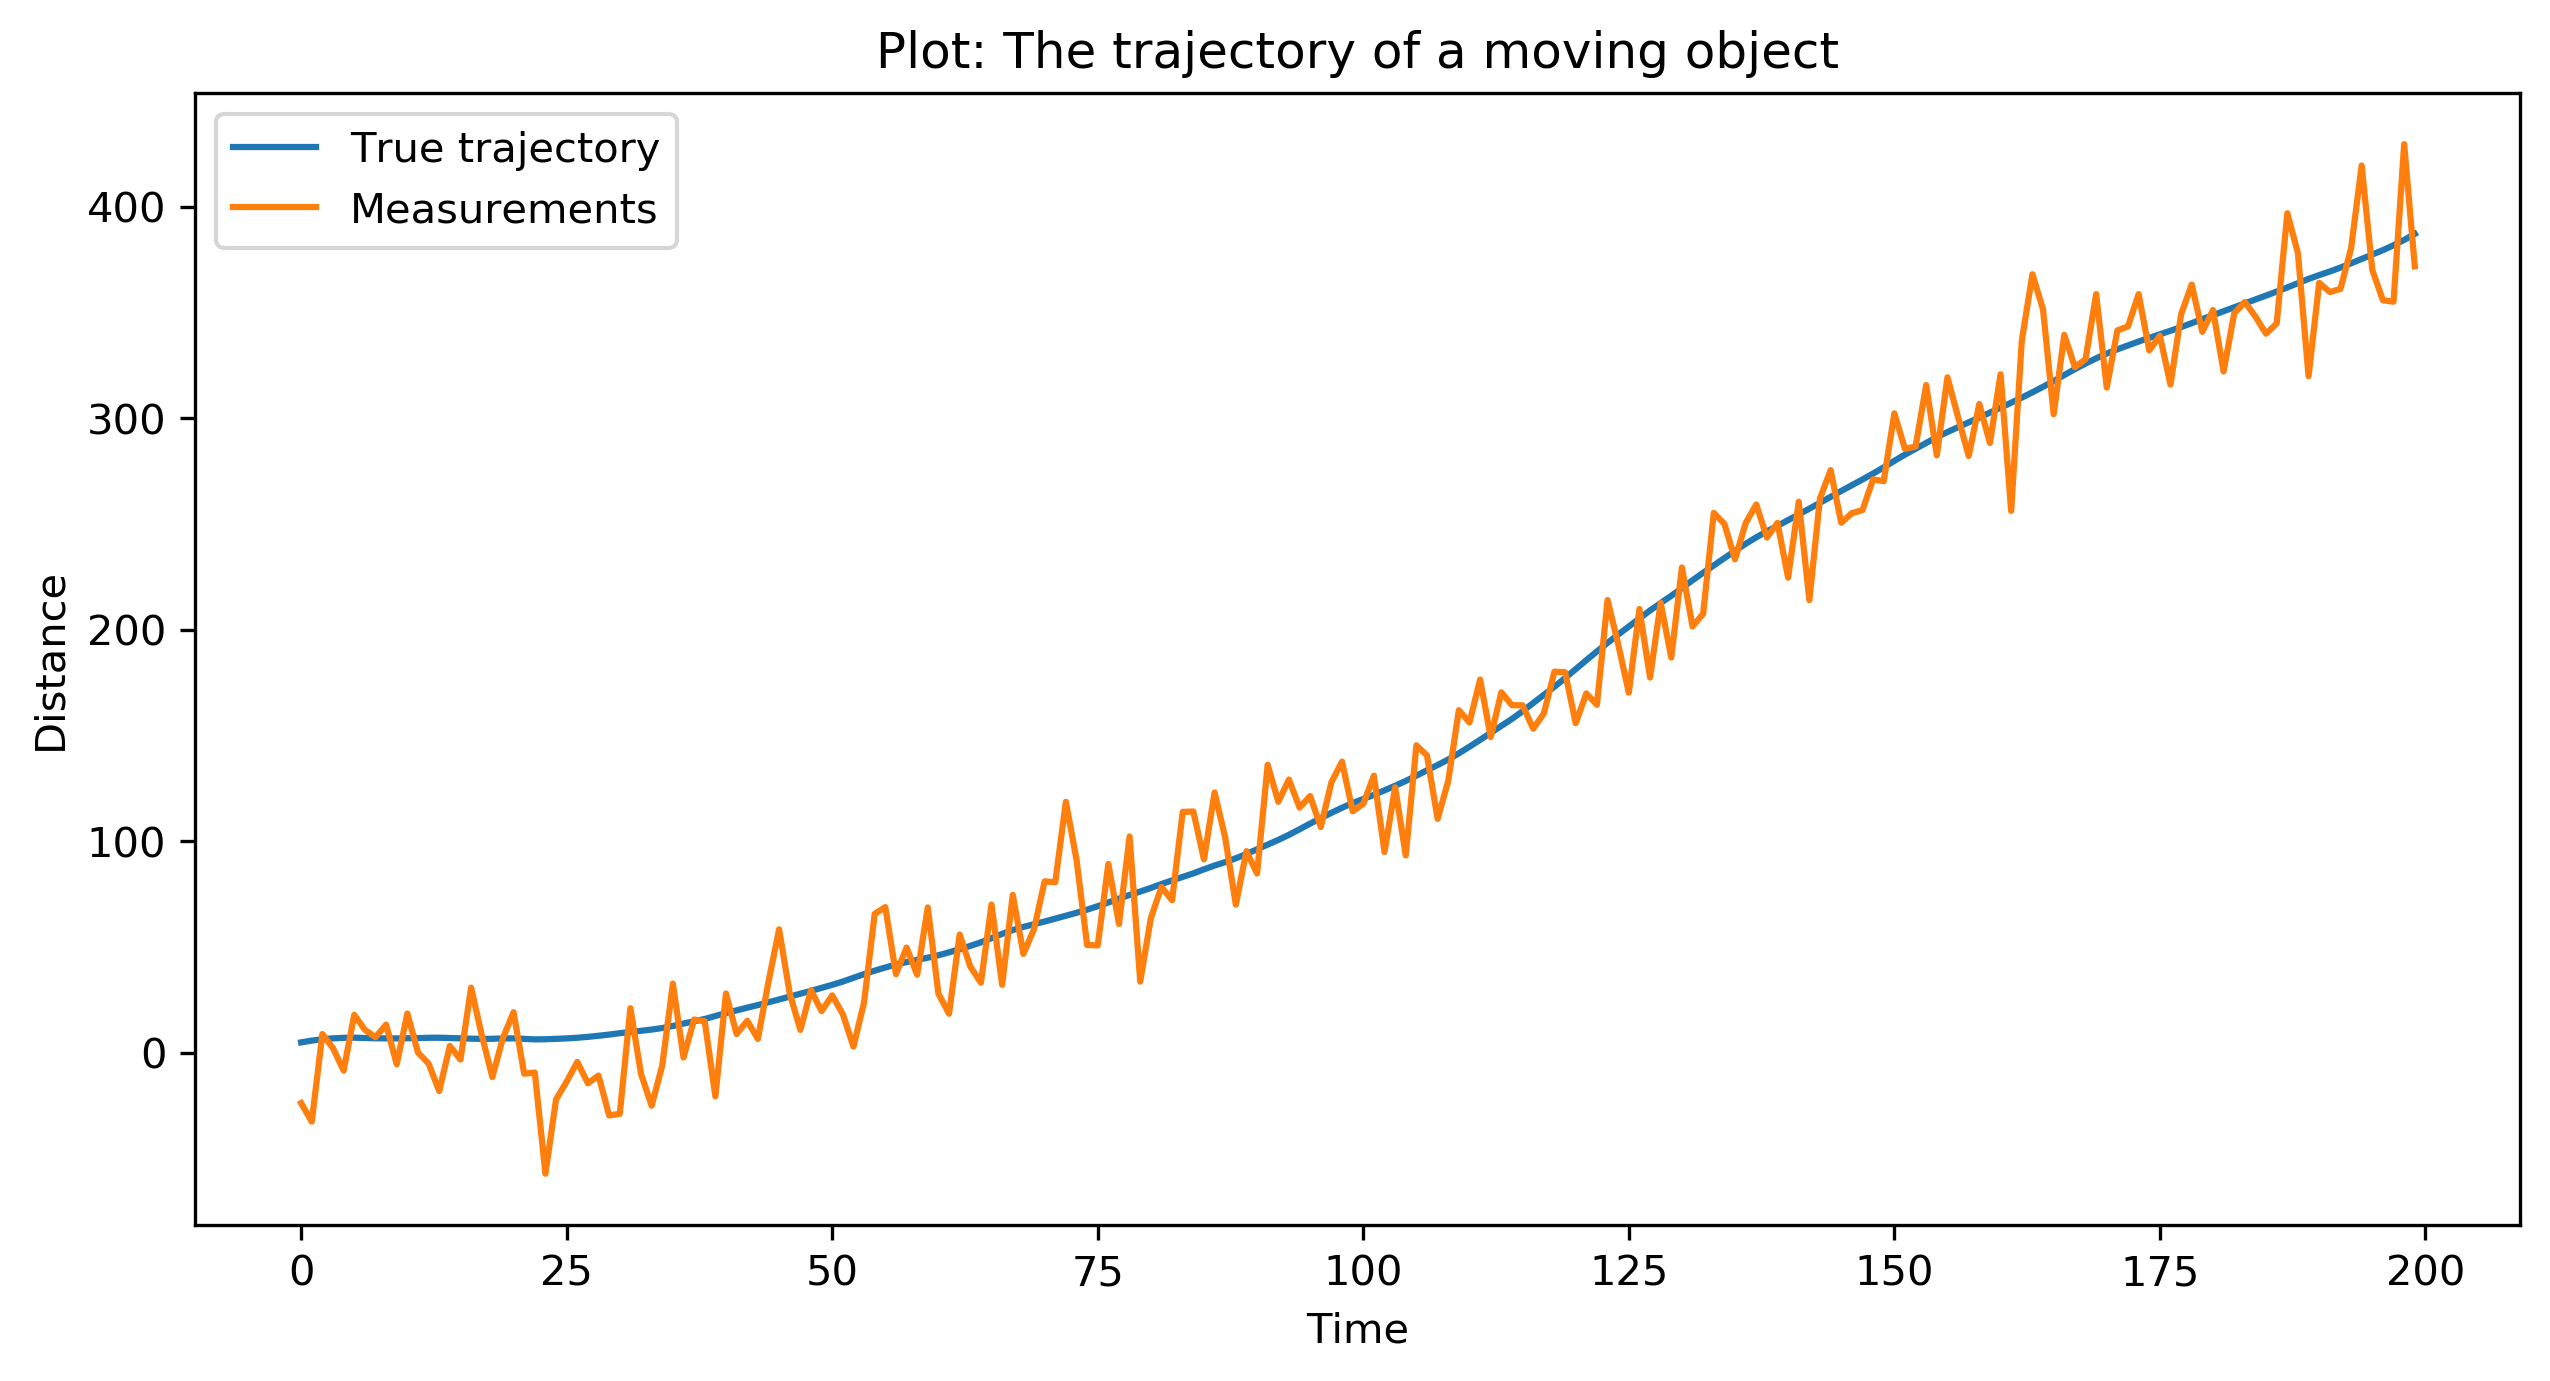

In [6]:
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: The trajectory of a moving object')    
plt.plot(X.T[0], label='True trajectory')
plt.plot(Z, label='Measurements')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show() 

In [7]:
#Kalman filtering
X0 = np.matrix((2,0))
P00 = np.matrix(((10000,0),(0,10000)))

#Covariance matrix Q
Q = np.matmul(G,G.T)*s2a
R = s2n
I = np.matrix(((1,0),(0,1)))

#Kalman filtering
def kalman(x):
    P = P00
    X_f = np.zeros([c,2])
    P_g = np.zeros([c,2,2])
    Pz_g = np.zeros([c,2,2])
    X_f[0] = X0
    for i in range (1,c):
        X_p = F.dot(np.asmatrix(X_f[i-1]).T)
        Pz = np.add(F.dot(P).dot(F.T),Q)
        frst = np.add(H.dot(Pz).dot(H.T),R)
        K = Pz.dot(H.T).dot(np.linalg.inv(frst))
        pre_scnd = np.subtract(x[i],H.dot(X_p))
        scnd = K.dot(pre_scnd)
        P = np.matmul(np.subtract(I,np.matmul(K,H)),Pz)
        X_f[i] = np.add(X_p,scnd).T
        P_g[i] = P
        Pz_g[i] = Pz
    #deleting first row
    Pz_g = np.delete(Pz_g, 0, 0)
    P_g = np.delete(P_g, 0, 0)
    return X_f, P_g, Pz_g
f, pf, pp = kalman(Z)

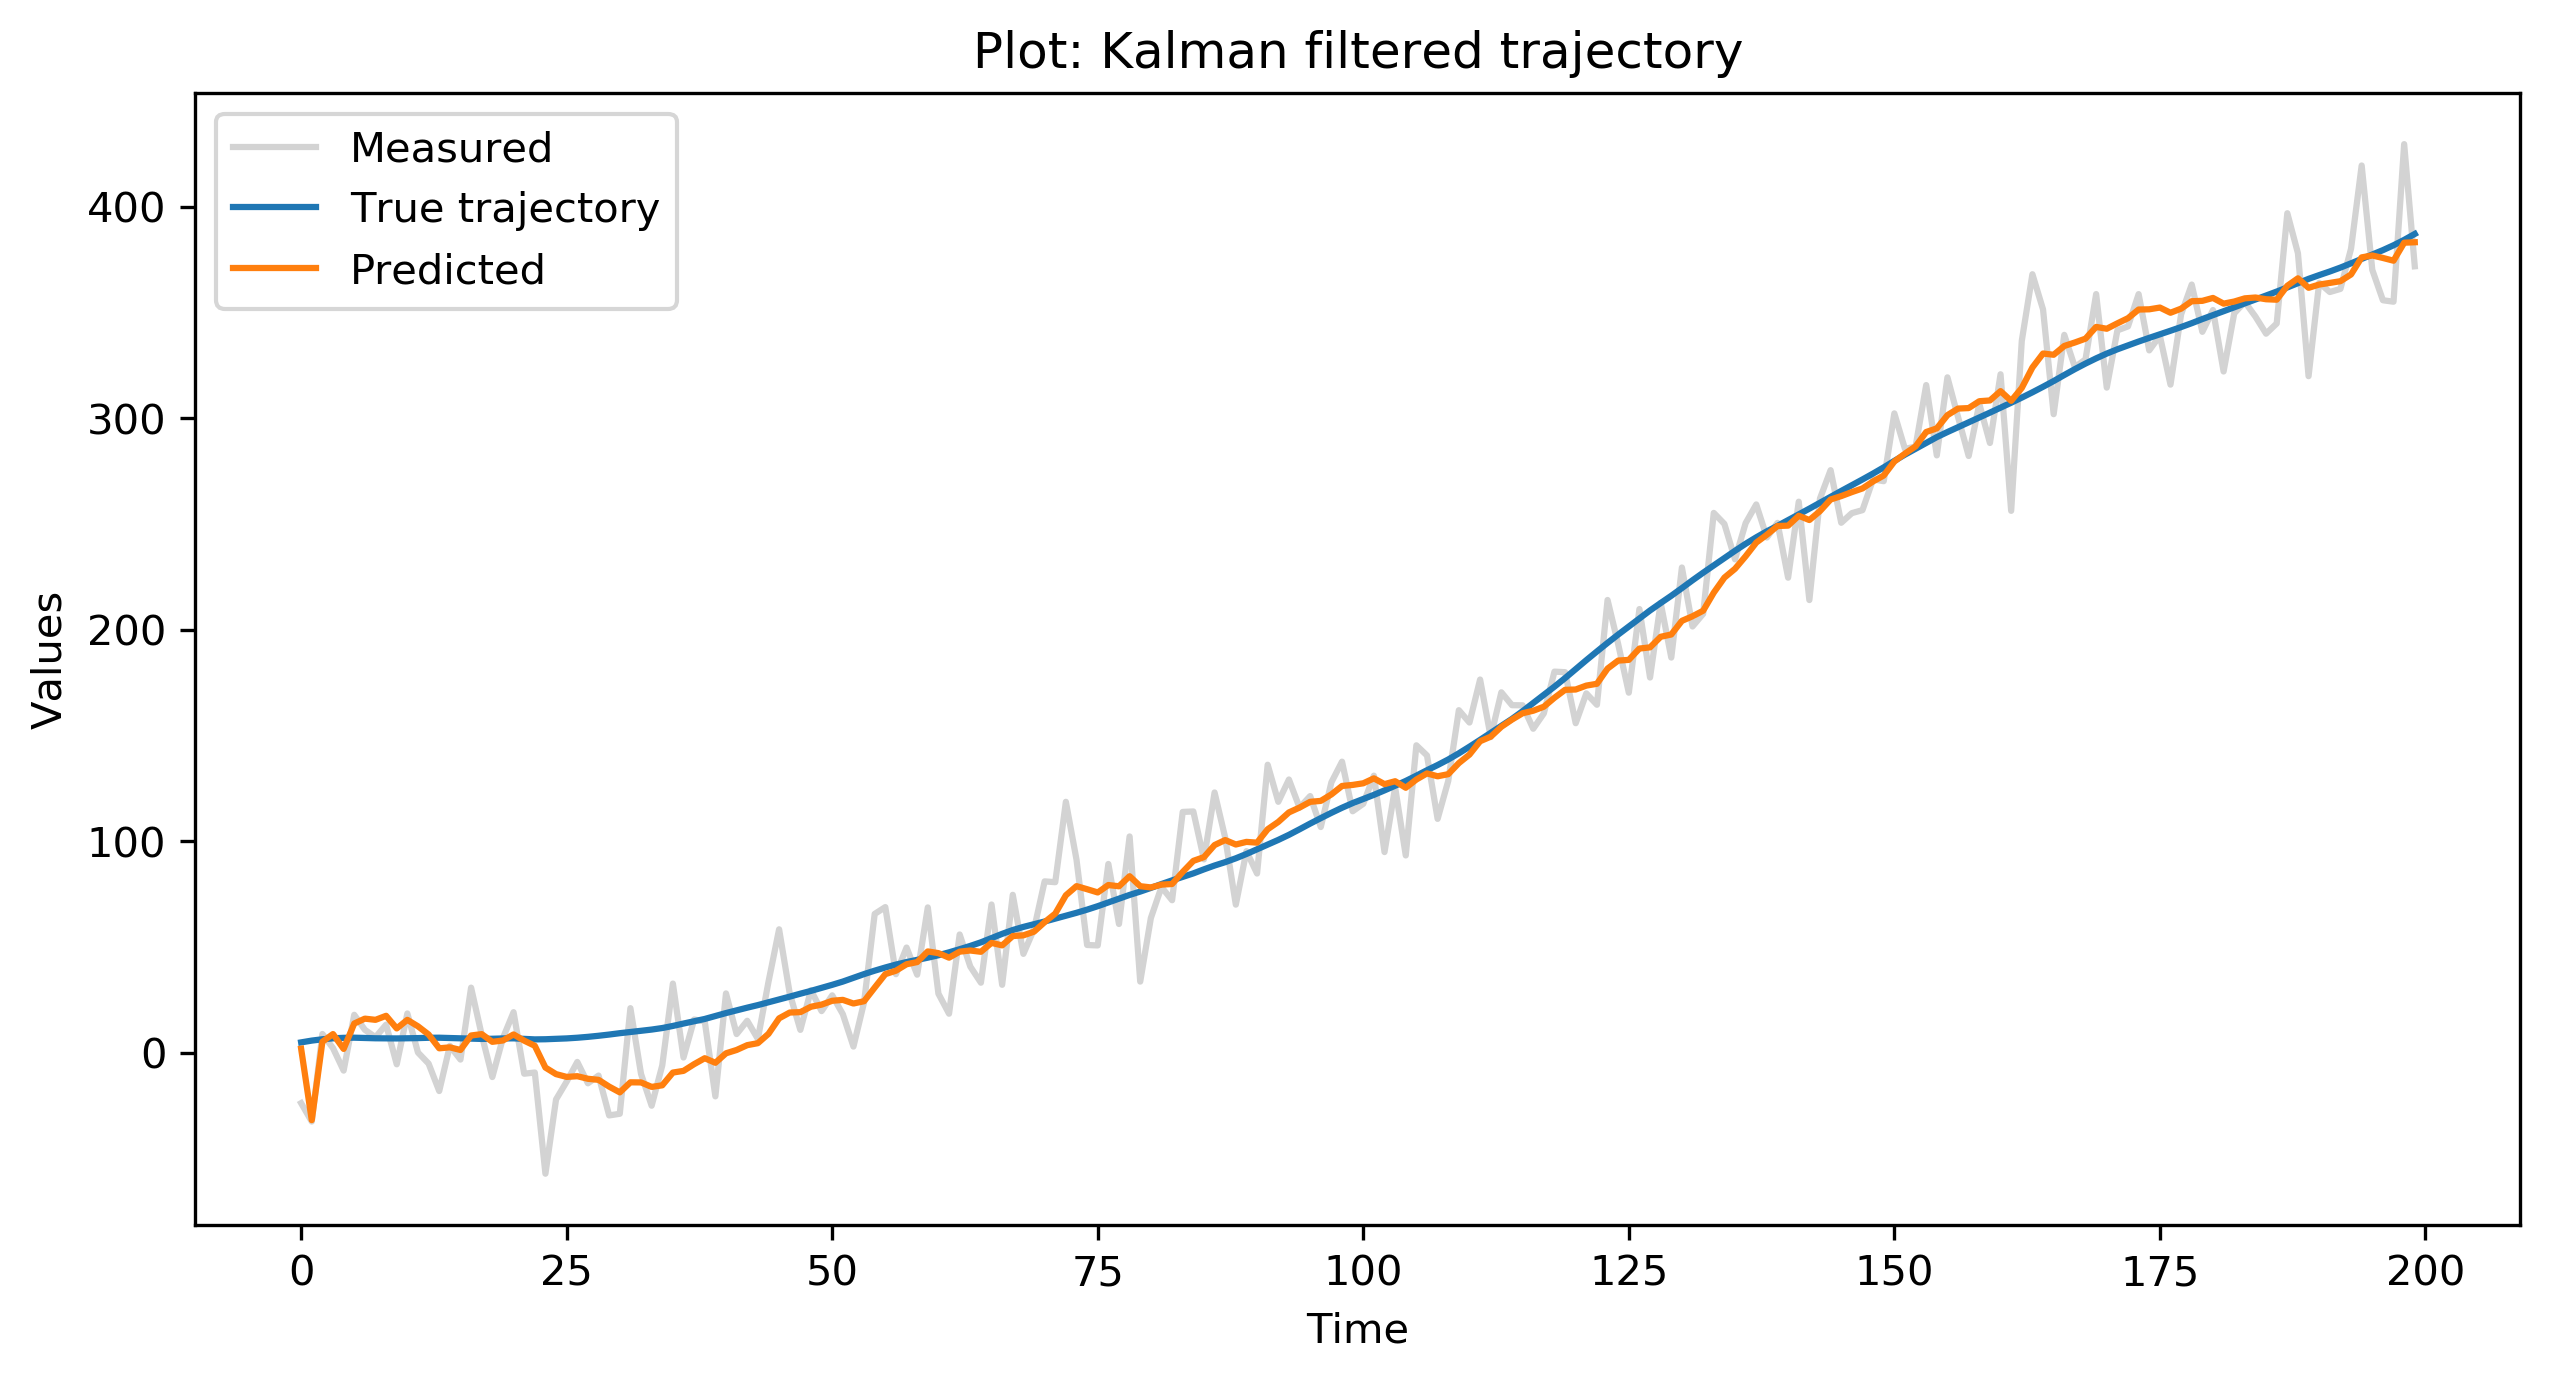

In [8]:
#Result of filtering
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Kalman filtered trajectory')
plt.plot(Z, label='Measured', c='lightgrey')
plt.plot(X.T[0], label='True trajectory')
plt.plot(f.T[0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [11]:
#Backward smoothing algorythm
def backward(x,pf,pp,fi):
    count = len(pf)
    A = np.zeros([count,2,2])
    res = np.zeros([count,2])
    res_P = np.zeros([count,2,2])
    res[count-1] = x[count-1]
    res_P[count-1] = pf[count-1]
    for i in range (count-2,0,-1):
        A[i] = pf[i].dot(fi.T).dot(np.linalg.inv(pp[i+1]))
        #to matrix
        c_x = np.asmatrix(x[i]).T
        ##
        pre_res = np.subtract(np.asmatrix(res[i+1]).T,fi.dot(c_x))
        res[i] = np.add(c_x,A[i].dot(pre_res)).T
        res_P[i] = np.add(pf[i],A[i].dot(A[i].T).dot(np.subtract(res_P[i+1],pp[i+1])))
    return res, res_P
b_x, b_p = backward(f,pf,pp,F)

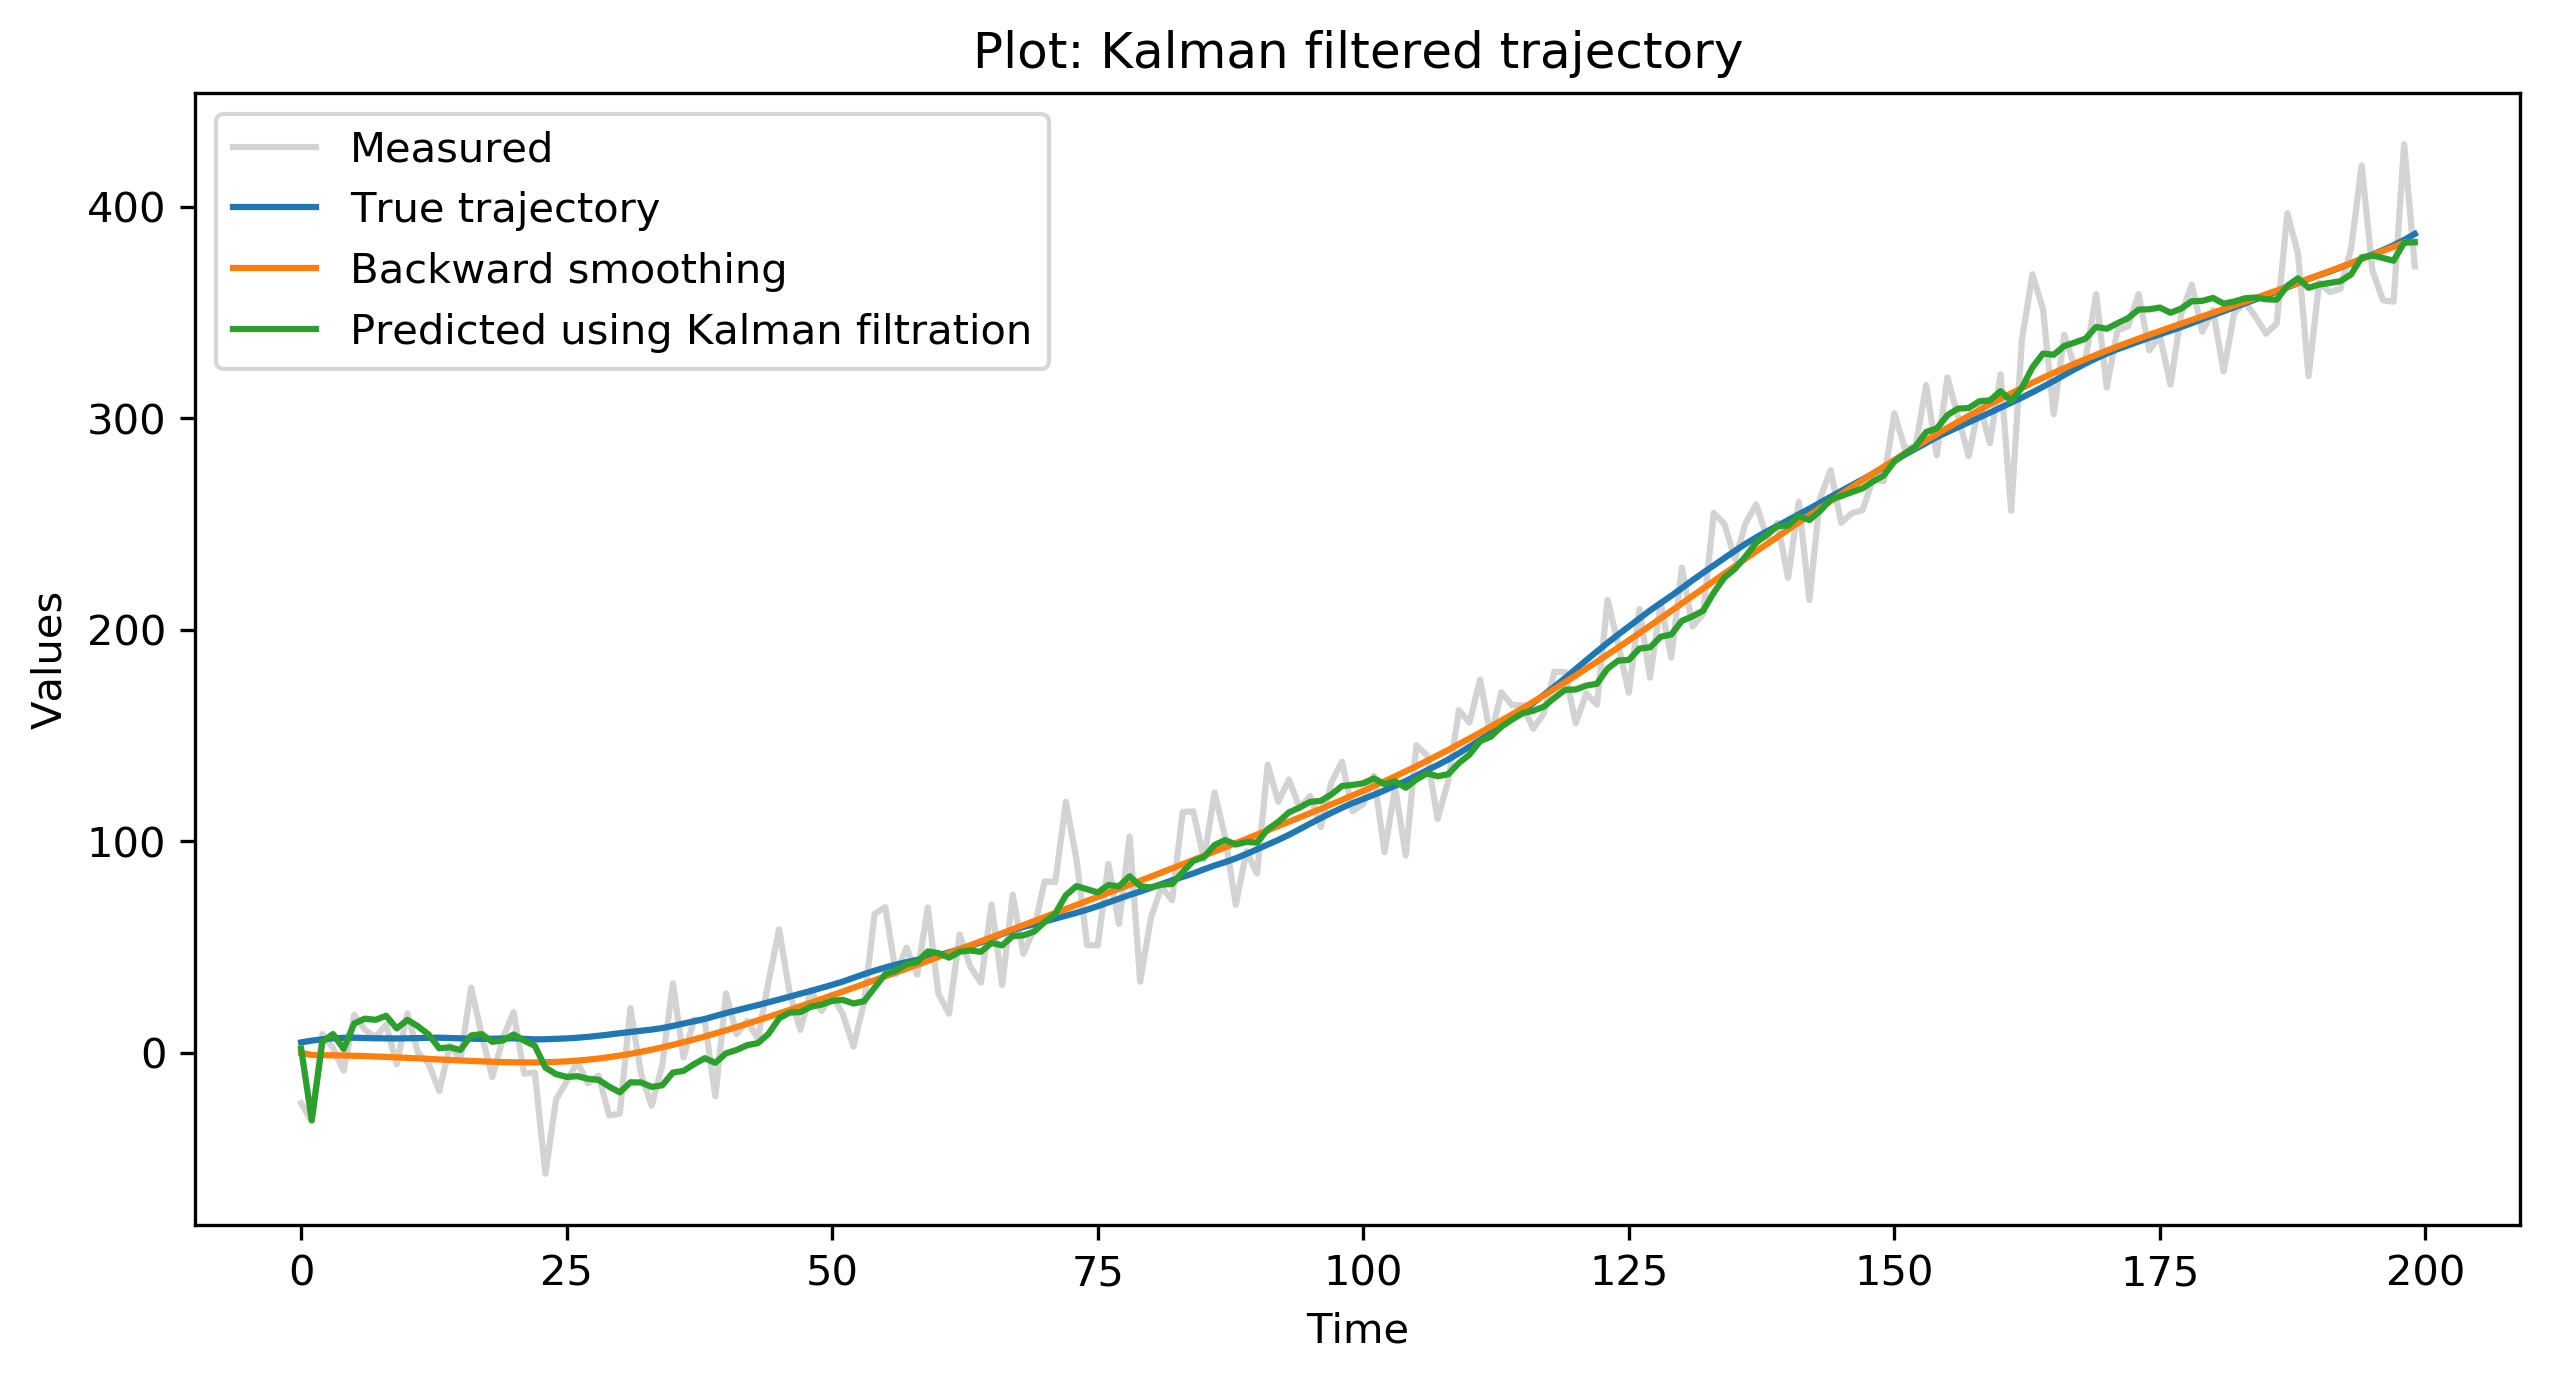

In [15]:
#Result of filtering
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot: Kalman filtered trajectory')
plt.plot(Z, label='Measured', c='lightgrey')
plt.plot(X.T[0], label='True trajectory')
plt.plot(b_x.T[0], label='Backward smoothing')
plt.plot(f.T[0], label='Predicted using Kalman filtration')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [17]:
#8 500 runs Kalman
def run(n):
    def gen():
        a = np.random.normal(0,sa,c)
        n = np.random.normal(0,sn,c)
        X1 = np.matrix((5,1))
        F = np.matrix(((1,t),(0,1)))
        G = np.matrix((t**2/2,t)).T
        H = np.matrix((1,0))

        X = np.zeros([c,2])
        X[0] = X1
        for i in range (1,c):
            frst = np.matmul(F,np.asmatrix(X[i-1]).T)
            scnd = G.dot(a[i-1])
            X[i] = np.add(frst,scnd).T
        Z = np.zeros(c)
        for i in range (c):
            Z[i] = H.dot(X[i])+n[i]
        return X.T,Z
    
    error = np.zeros(c)
    for i in range (n):
        cur_x,cur_z = gen()
        xk_res, pf_res, pp_res = kalman(cur_z)
        res, pn_res = backward(xk_res,pf_res,pp_res,F)
        s = np.power(np.subtract(cur_x[0],res[0]),2)    
        error = np.add(s,error)
    final = np.zeros(c)
    for k in range (2,c):
        final[k] = np.sqrt(error[k]/(n-1))
    return final

In [ ]:
runs = run(500)